# Предсказание ВВП Ганы

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import seasonal_decompose, ARIMA, adfuller
from pmdarima import auto_arima

warnings.filterwarnings('ignore')
pio.templates.default = 'plotly_dark'
plt.style.use('seaborn-v0_8-darkgrid')
# pio.renderers.default = 'png'

In [3]:
data = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col='year').rename(columns={'GDP (current US$)': 'GDP'})
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Разложение данных на тренд, сезонность и шум.

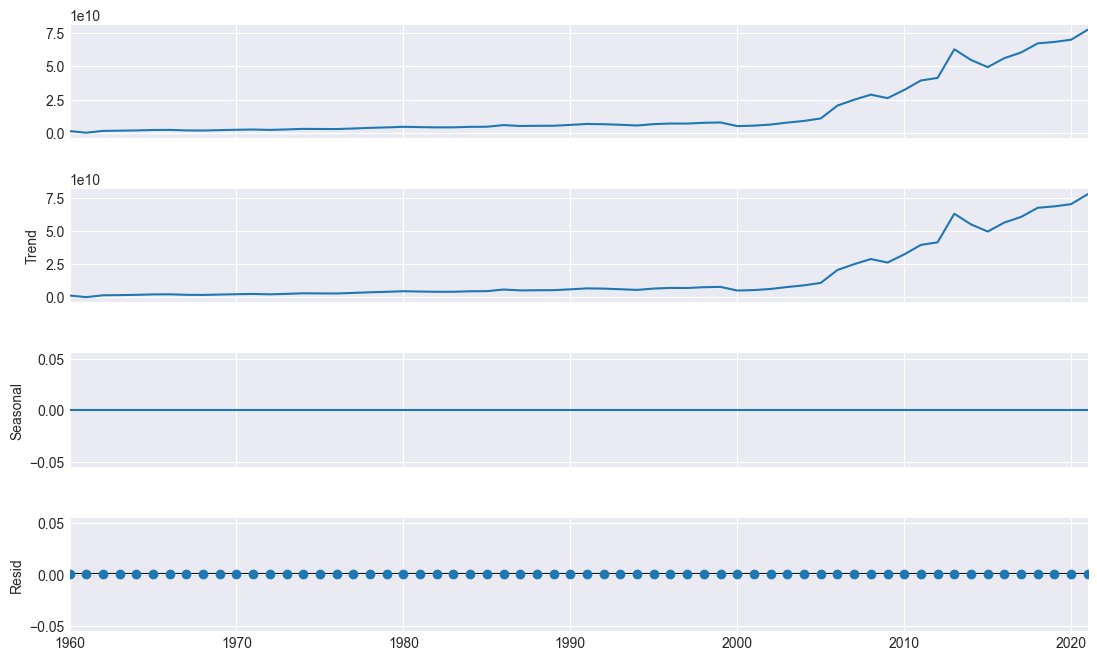

In [4]:
decomposed_data = seasonal_decompose(data)
figure = decomposed_data.plot()
figure.set_figwidth(12)
figure.set_figheight(7)
plt.show();

В данных есть тренд (график которого совпадает с графиком исходных данных), полностью отсутствует сезонность, шум находится в нуле.

Разделим выборку на train и test, в тестовой оставим последние 3 года.

In [5]:
train, test = data[data.index.year < 2019], data[data.index.year >= 2019]
print(
    'Train shape:', train.shape,
    '\nTest shape:', test.shape
)

Train shape: (59, 1) 
Test shape: (3, 1)


Построение графика скользящего среднего

In [6]:
figure = go.Figure()
for i in range(2, 7, 2):
    rolling_data = data.rolling(window=i).mean()
    figure.add_trace(
        go.Scatter(
            x=rolling_data.index,
            y=rolling_data.GDP,
            name=f'Rolling mean<br>(window={i})',
        )
    )
figure.add_trace(
    go.Scatter(
        x=data.index,
        y=data.GDP,
        name='Data',
        mode='lines+markers',
        line=dict(color='white')
    )
).update_layout(
    width=1500,
    height=700,
    title='<b>Исходный временной ряд vs. скользящее среднее</b>',
    xaxis_title='GDP',
    yaxis_title='Year',
    font=dict(size=16)
)
figure.show()

Скользящее среднее с окном 3 довольно хорошо описывает исходные данные, но есть некоторые неточности, например, промежуток между 2013 и 2015 годами.

**Оценка ряда на стационарность, выбор модели *ARMA/ARIMA***

In [7]:
adfuller_result = adfuller(data)
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


Количество дифференцирований, необходимых для сведения ряда к стационарному: 3


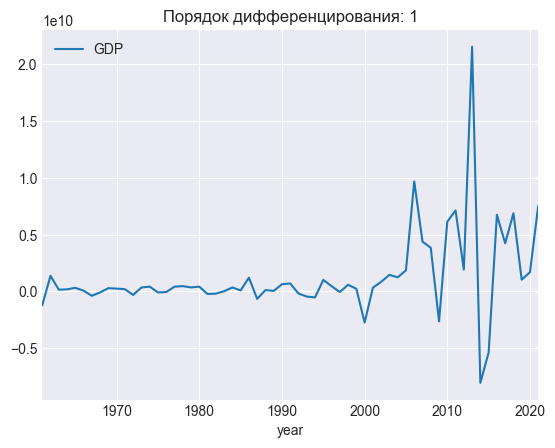

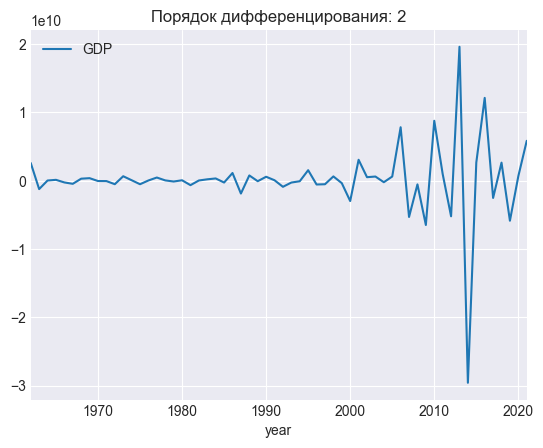

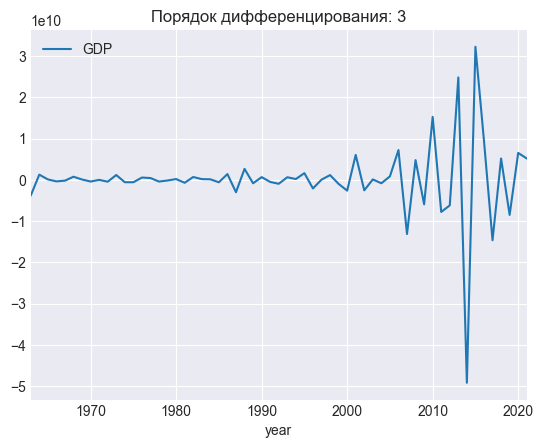

In [8]:
def num_of_diffs(data):
    n_diff = 0
    data_diff = data.diff().dropna()
    while True:
        n_diff += 1
        adfuller_result = adfuller(data_diff)
        data_diff.plot().set_title(f'Порядок дифференцирования: {n_diff}')
        if adfuller_result[0] <= adfuller_result[4]['10%']:
            break
        data_diff = data_diff.diff().dropna()
    print(f'Количество дифференцирований, необходимых для сведения ряда к стационарному: {n_diff}')
    
plt.show()
num_of_diffs(data)

Параметр d=3, полагаясь тест Дики-Фуллера.

Т.к. исходные данные нестационарны, то будем использовать ARIMA.

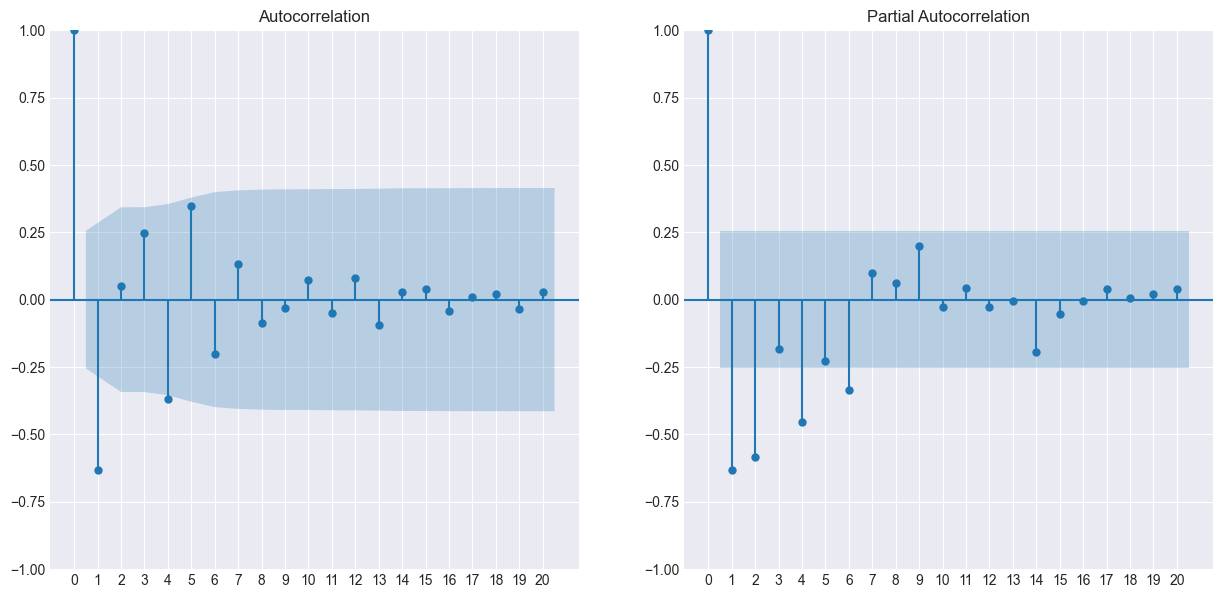

In [9]:
def plot_acf_pcf(data:pd.DataFrame):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    plot_acf(x=data, ax=ax[0], lags=20)
    plot_pacf(x=data, ax=ax[1], lags=20, method='ywm')
    ax[0].xaxis.set_ticks(range(0, 21))
    ax[1].xaxis.set_ticks(range(0, 21))
    plt.show()

data_diff = data['GDP'].diff().diff().diff().dropna()
plot_acf_pcf(data_diff)

Из коррелограмм имеем следующее:

* параметр p=2 (правый график частичной автокорреляции);
* параметр q=1 (левый график автокорреляции);

**Инициализируем модель ARIMA с подобранными параметрами, обучим её и узнаем коэффициент *AIC***

In [10]:
order = 2, 3, 1
arima = ARIMA(train, order=order).fit()
arima.aic

2659.230811357536

Попробуем подобрать параметры автоматически с помощью pmdarima

In [11]:
best_arima = auto_arima(
    y=train,
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=6,
    seasonal=False
)

print(
    'AIC:', best_arima.aic(),
    '\nParams:', best_arima.order
)

AIC: 2659.230811357536 
Params: (2, 3, 1)


Значения не поменялись, значит мы изначально подобрали наилучшую комбинацию.

Визуализируем предсказания модели с наилучшими подобранными параметрами.

In [12]:
y_pred, conf_int = best_arima.predict(3, return_conf_int=True, alpha=0.05)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data['GDP'],
        name='Initial data',
        line=dict(color='white'),
        mode='lines+markers'
    )
).add_trace(
    go.Scatter(
        x=y_pred.index,
        y=y_pred.values,
        name='Predicted data<br>(ARIMA)',
        line=dict(color='#FF00FF'),
        mode='lines'
    )
).add_trace(
    go.Scatter(
        x=y_pred.index,
        y=conf_int[:, 0],
        line=dict(color='#7FFFD4'),
        line_dash='dash',
        mode='lines',
        name='Confidence<br>intervals (95%)'
    )
).add_trace(
    go.Scatter(
        x=y_pred.index,
        y=conf_int[:, 1],
        line=dict(color='#7FFFD4'),
        line_dash='dash',
        mode='lines',
        showlegend=False,
        name='Confidence<br>intervals (95%)'
    )
).update_layout(
    width=1500,
    height=900,
    title='<b>Исходный временной ряд vs. предсказания <i>ARIMA</i></b>',
    font=dict(size=16),
    xaxis_title='<b>Year</b>',
    yaxis_title='<b>GDP</b>'
)
fig.show()

## Вывод

Хоть модель немного завысила реальные показатели, но по графику видно, что получилось выявить зависимость, и модель можно использовать для примерных предсказаний на будущее.

## Интерполяция и сэмплирование

Проверка пропущенных значений для всех дат на начало года

In [13]:
data.asfreq('AS').isna().sum()

GDP    0
dtype: int64

Пропущенных значений для дат не найдено

**Проверка пропущенных значений, скрывающимися за нулями**

In [14]:
data[data['GDP'] == 0]

,GDP
year,
1961-01-01,0.0


Есть 1 пропуск, заполненный нулём.

Замена пропуска на np.nan

In [15]:
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)

Заполнение пропущенного значения с использованием интерполяции

In [16]:
data['GDP'].interpolate(method='linear', inplace=True)

Проверка на стационарность

In [17]:
adfuller_result = adfuller(data)
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


Подбираем порядок дифференцирования

Количество дифференцирований, необходимых для сведения ряда к стационарному: 3


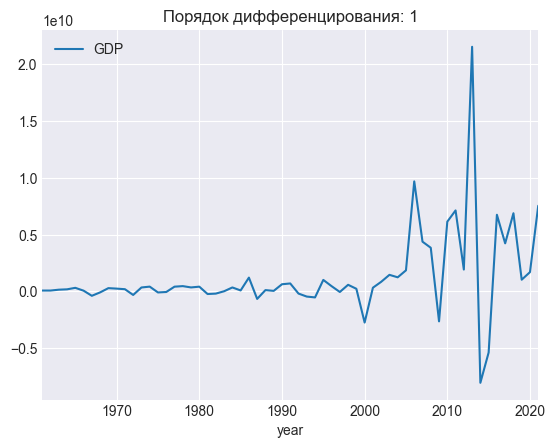

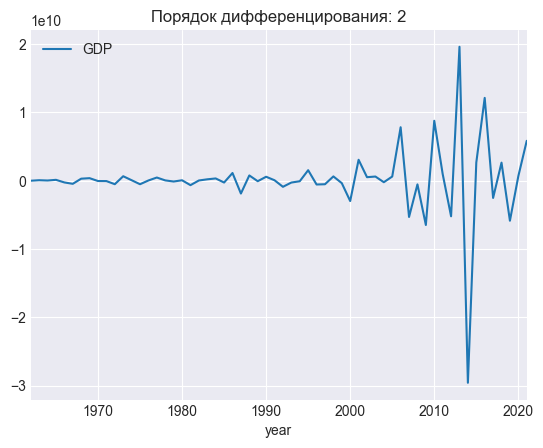

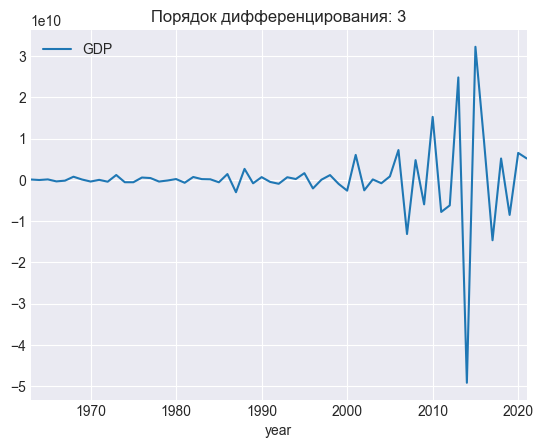

In [18]:
num_of_diffs(data)

Построение коррелограмм

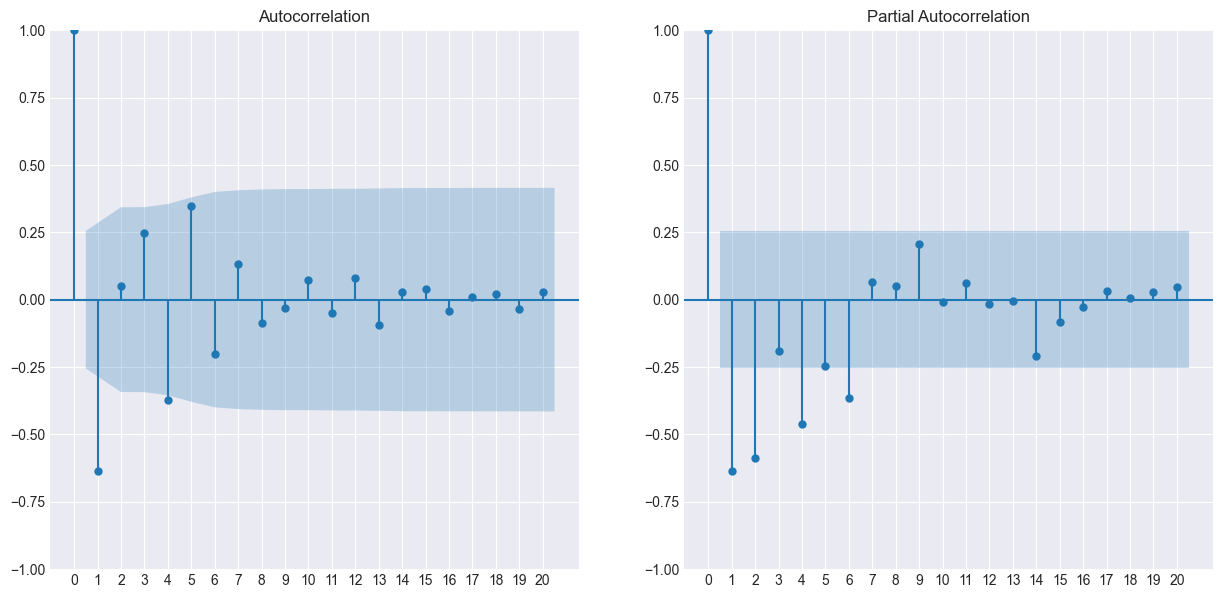

In [19]:
data_diff = data['GDP'].diff().diff().diff().dropna()
plot_acf_pcf(data_diff)

Снова разделим выборку на train и test, в которых уже нет пропущенных значений.

In [20]:
train, test = data[data.index.year < 2019], data[data.index.year >= 2019]

**Подбор параметров для *ARIMA***

In [21]:
best_arima = auto_arima(
    y=train,
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=6,
    seasonal=False
)

print(
    'AIC:', best_arima.aic(),
    '\nParams:', best_arima.order
)

AIC: 2659.2261049694457 
Params: (2, 3, 1)


Значение практически не поменялось (без интерполяции целая часть тоже была ``2659``).

### Вывод

Интерполирование одного пропущенного значения никак не повлияло на качество модели ARIMA.

### Волатильность и модели ARCH/GARCH

Волатильность

In [22]:
data['GDP_vol'] = data['GDP'].pct_change(1).mul(100).abs()
data.head()

,GDP,GDP_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


In [23]:
data_vol = data['GDP_vol'].dropna()

In [24]:
px.line(
    x=data_vol.index,
    y=data_vol,
    width=1200,
    height=700,
    title='<b>Волатильность</b>',
    labels={'y': 'GDP_vol', 'x': 'Year'},
    color_discrete_sequence=['#98FB98']
).update_layout(font=dict(size=16)).show()

Проверка ряда на стационарность, выбор параметров q и p.

In [25]:
adfuller_result = adfuller(data_vol)
if adfuller_result[0] > adfuller_result[4]['5%']: 
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд стационарен


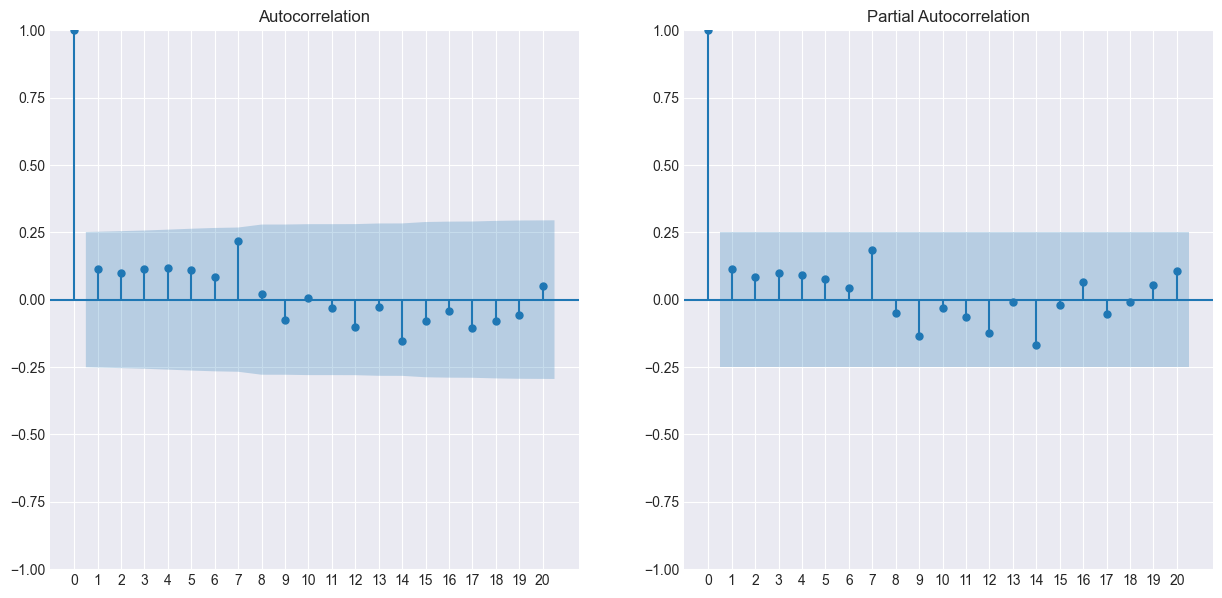

In [26]:
plot_acf_pcf(data_vol)

Из коррелограмм делаем выводы, что нам подходят следующие параметры: p=7, q=7.

**Построение моделей GARCH и *LinearRegression***

In [27]:
# Линейная регрессия, обучаем на train (не включая последние 3 наблюдения)
X, y = pd.DataFrame(data_vol.index.year), data_vol
lr_model = LinearRegression().fit(X.iloc[:-3], y.iloc[:-3])
# GARCH-модель, также обучаем на train
model_results = arch_model(y, X, p=7, q=7, vol='GARCH').fit(last_obs='2019-01-01', update_freq=10)
display(model_results.summary())
# Делаем предсказания для всей выборки, включая train и test
predictions_df = model_results.forecast(start='1961-01-01').variance.rename(columns={'h.1': 'GARCH'})
predictions_df['LR'] = lr_model.predict(X)

Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Sat, Apr 19 2025   Df Residuals:                       57
Time:                        06:07:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

Строим графики сравнения результатов моделей

In [28]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data['GDP_vol'],
        name='GDP_vol',
        line=dict(color='white')
    )
).add_trace(
    go.Scatter(
        x=predictions_df.index[:-3],
        y=predictions_df['GARCH'][:-3],
        name='Predicted <i>GARCH</i> (train)',
        line=dict(color='#F08080', dash='dash')
    )
).add_trace(
    go.Scatter(
        x=predictions_df.index[-3:],
        y=predictions_df['GARCH'][-3:],
        name='Predicted <i>GARCH</i> (test)',
        line=dict(color='#FF0000', dash='dash')
    )
).add_trace(
    go.Scatter(
        x=predictions_df.index[:-3],
        y=predictions_df['LR'][:-3],
        name='Predicted <i>LinearRegression</i> (train)',
        line=dict(color='#3CB371', dash='dash')
    )
).add_trace(
    go.Scatter(
        x=predictions_df.index[-3:],
        y=predictions_df['LR'][-3:],
        name='Predicted <i>LinearRegression</i> (test)',
        line=dict(color='#00FF00', dash='dash')
    )
).update_layout(
    width=1500,
    height=700,
    title='<b>Исходная волатильность vs. <i>GARCH</i> и <i>LinearRegression</i></b>',
    yaxis_title='GDP_vol',
    xaxis_title='Year',
    font=dict(size=16),
    yaxis_range=[-10, 200]
).show()

In [29]:
mse_garch = mean_squared_error(data_vol, predictions_df['GARCH']).round(2)
mse_LR = mean_squared_error(data_vol, predictions_df['LR']).round(2)
print(
    'MSE (GARCH):', mse_garch,
    '\nMSE (LinearRegression):', mse_LR
)

MSE (GARCH): 379461.82 
MSE (LinearRegression): 174.13


### Вывод

GARCH не смогла уловить зависимости в данных волатильности. Думаю, для того, чтобы LinearRegression показала более точный результат, необходимо заняться feature engineering.

## NeuralProphet

In [30]:
# Делаем датафрейм для обучения и последующего предсказания
prophet_df = pd.DataFrame({
    'ds': data.index[1:],
    'y': data.loc['1961-01-01':, 'GDP_vol'].values,
})
# Разделяем на train и test выборки
train, test = prophet_df[prophet_df['ds'] <= '2018-01-01'], prophet_df[prophet_df['ds'] > '2018-01-01']
# Обучаем модель
nprophet = NeuralProphet()
metrics = nprophet.fit(train)
# Делаем предсказания для всего датафрейма, включая train и test
forecast = nprophet.predict(prophet_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.276% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as YS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 310


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (8) is too small than the required number                     for the learning rate finder (204). The results might not be optimal.
Finding best initial lr: 100%|██████████| 204/204 [00:00<00:00, 289.76it/s]


Training: |          | 0/? [00:09<?, ?it/s, v_num=0, train_loss=0.139, reg_loss=0.000, MAE=7.160, RMSE=10.20, Loss=0.126, RegLoss=0.000]

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.361% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.361% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - YS


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.46it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [31]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data.index,
        y=data['GDP_vol'],
        name='GDP_vol',
        line=dict(color='white'),
        mode='markers'
    )
).add_trace(
    go.Scatter(
        x=forecast.loc[train.index, 'ds'],
        y=forecast.loc[train.index, 'yhat1'],
        line=dict(color='#FA8072'),
        name='Predicted <i>NeuralProphet</i> (train)',
        
    )
).add_trace(
    go.Scatter(
        x=forecast.loc[test.index, 'ds'],
        y=forecast.loc[test.index, 'yhat1'],
        line=dict(color='#FF0000'),
        name='Predicted <i>NeuralProphet</i> (test)',
    )
).update_layout(
    width=1500,
    height=700,
    title='<b>Исходная волатильность vs. <i>NeuralProphet</i></b>',
    yaxis_title='GDP_vol',
    xaxis_title='Year',
    font=dict(size=16),
)
fig.show()

In [32]:
mse_prophet = mean_squared_error(forecast['y'], forecast['yhat1']).round(2)
print('MSE (NeuralProphet):', mse_prophet)

MSE (NeuralProphet): 173.16


Оценка качества моделей для предсказания волатильности

Видно, что для данного датасета без тщательного подбора гиперпараметров (брали значения "на глаз" по графикам авто-корреляции) GARCH очень плохо показала себя. LinearRegression требует вмешательства в виде feature engineering для улучшения метрики (слишком мало признаков, всего 1, предсказание похоже на предсказание среднего). Наилучший результат показала модель NeuralProphet.